# TensorFlow神经网络模型处理鸢尾花分类问题



In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk  # scikit-learn,用于拆分数据集.
from sklearn.model_selection import train_test_split

from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.metrics import accuracy_score

In [43]:
dataset_path = './iris.csv'


## 1. 数据可视化


进行机器学习分类之前,先使用matplotlib对数据进行可视化处理,了解数据分布情况.


In [44]:
# 配置matplotlib
plt.rcParams['font.family']='SimHei'


In [45]:
# 导入数据
iris = pd.read_csv(dataset_path)

iris.info()
iris.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


绘制散点图表示数据分布情况.


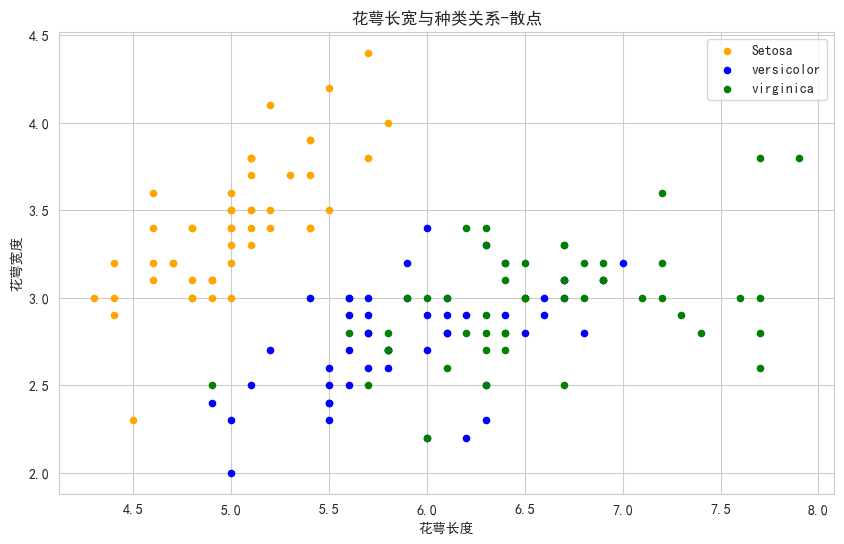

In [46]:
fig = (iris[iris.Species == 'Iris-setosa'].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='orange',
                                                label='Setosa'))
iris[iris.Species == 'Iris-versicolor'].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='blue',
                                             label='versicolor', ax=fig)
iris[iris.Species == 'Iris-virginica'].plot(kind='scatter', x='SepalLengthCm', y='SepalWidthCm', color='green',
                                            label='virginica', ax=fig)
fig.set_xlabel("花萼长度")  # 设置x标签
fig.set_ylabel("花萼宽度")  # 设置y标签
fig.set_title("花萼长宽与种类关系-散点")  # 设置标题
fig = plt.gcf()  # 获取最近的图像
fig.set_size_inches(10, 6)  # 设置尺寸
plt.show()  # 显示图片


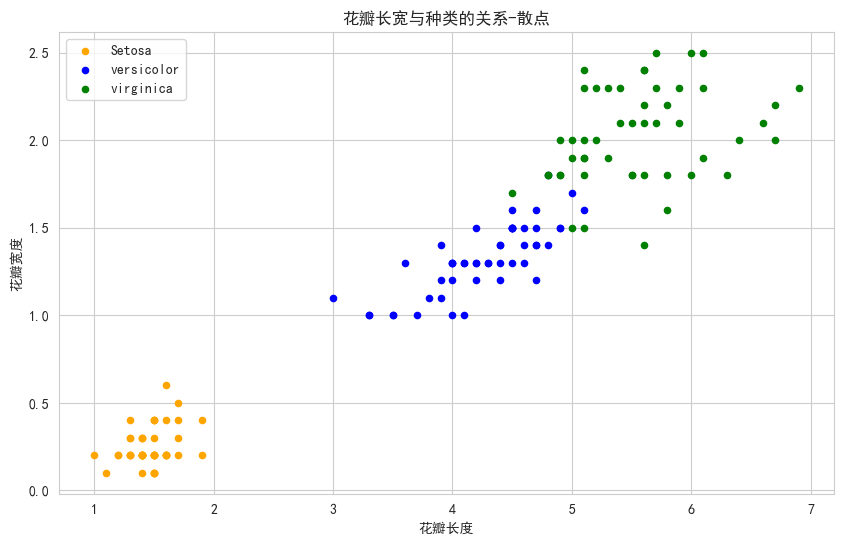

In [47]:
fig = iris[iris.Species == 'Iris-setosa'].plot.scatter(x='PetalLengthCm', y='PetalWidthCm', color='orange',
                                                       label='Setosa')
iris[iris.Species == 'Iris-versicolor'].plot.scatter(x='PetalLengthCm', y='PetalWidthCm', color='blue',
                                                     label='versicolor', ax=fig)
iris[iris.Species == 'Iris-virginica'].plot.scatter(x='PetalLengthCm', y='PetalWidthCm', color='green',
                                                    label='virginica', ax=fig)
fig.set_xlabel("花瓣长度")  # petal length
fig.set_ylabel("花瓣宽度")  # petal width
fig.set_title("花瓣长宽与种类的关系-散点")
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.show()


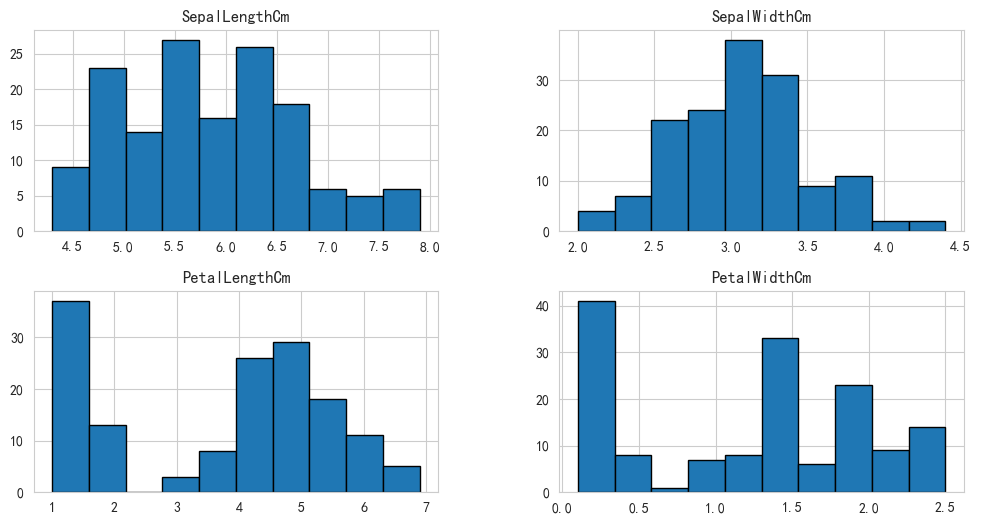

In [48]:
iris.drop(['Id'],axis=1).hist(edgecolor='black', linewidth=1)
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

## 2. 数据处理


### Pandas读取数据并转化为NumPy

说明:Pandas读取csv文件后得到一个DataFrame对象,通过该df对象的value属性,是否可以将其值以NumPy的ndarray的方式获取?



In [49]:
iris = pd.read_csv(dataset_path)

iris.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [50]:
# 事实证明,取values的时候,返回的数据本身就是一个ndarray...
type(iris.values)


numpy.ndarray

### 拆分DataFrame



In [51]:
# 这一步的目的是获取某一列的值,最终要求将能够把DataFrame的Species列分离出来.
species = iris.loc[:,'Species']  # 获取列
type(species)


pandas.core.series.Series

In [52]:
features = iris.loc[:, 'SepalLengthCm':'PetalWidthCm']  # 切片的方式获取特征所在列
# features = iris.iloc[:, 1:2]  # 隐式切片
features.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [53]:
type(features)

pandas.core.frame.DataFrame

获取到指定的特征列(DataFrame)和指定的结果列(Series)之后,将其转换为ndarray.


In [54]:
species = species.values

type(species), species.shape


(numpy.ndarray, (150,))

In [55]:
features = features.values

type(features), features.shape


(numpy.ndarray, (150, 4))

到这里还没完,下面输出一下features和species做一下测试:


In [56]:
features[10:20]

array([[5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

可以看到,features每一行表示一个样本,每一列表示一个特征,数据全部都是浮点型数据.

下面输出species做测试:


In [57]:
species[10:20]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa'], dtype=object)

可见,species每一行表示一个样本,每一列表示一个结果.

但是,species的每个数据都是一个字符串,这将无法参与训练神经网络,所以需要转换成整形数据.


In [58]:
species,categories = pd.factorize(species)


通过上述代码,可以将species中的字符串转换成整形数据.

此外,该函数返回两个参数,第一个保存了转换后的数据,第二个保存了转换后的类别.


In [59]:
categories

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [60]:
len(categories)

3

In [61]:
species

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [62]:
len(species)

150

### 分割训练集,验证集,测试集

第一个是features,该矩阵的每一行表示一组特征,每一列表示某一个特征;

第二个是species,该矩阵为1x150,保存了全部的物种结果.



至此,已经获得了两个完善的数据集,下一步的任务就是对数据集进行分割,用于训练和验证神经网络模型.

拆分数据集主要通过scikit-learn(sk)的`sk.model_selection.train_test_split()`函数,并将数据集二八开进行拆分(八成作为训练集).


In [63]:
random_state=1

x_train, x_tmp, y_train, y_tmp = train_test_split(features, species, test_size=0.4, random_state=random_state)


In [64]:
x_cv, x_test, y_cv, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=random_state)


In [65]:
x_train.shape, y_train.shape

((90, 4), (90,))

In [66]:
x_train[:5]

array([[4.8, 3.4, 1.6, 0.2],
       [5.7, 2.5, 5. , 2. ],
       [6.3, 2.7, 4.9, 1.8],
       [4.8, 3. , 1.4, 0.1],
       [4.7, 3.2, 1.3, 0.2]])

In [67]:
y_train[10:20]

array([1, 2, 2, 0, 1, 1, 2, 1, 2, 1], dtype=int64)

## 3. 神经网络模型

### 创建神经网络模型


In [68]:
# 创建模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=48, activation='relu', name='l1'),
    tf.keras.layers.Dense(units=12, activation='relu', name='l2'),
    tf.keras.layers.Dense(units=3, activation='linear', name='output'),  # 输出层
])



创建好以后,需要先编译模型,

第三个参数metrics用于值定在训练过程中药监控的指标是准确性.


In [69]:
# 编译模型
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [70]:
model.fit(x_train, y_train, epochs=50, validation_data=(x_cv, y_cv))


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5757 - loss: 1.9461 - val_accuracy: 0.5667 - val_loss: 1.9836
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6174 - loss: 1.7706 - val_accuracy: 0.6333 - val_loss: 1.7000
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6403 - loss: 1.5239 - val_accuracy: 0.6333 - val_loss: 1.4735
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6748 - loss: 1.3394 - val_accuracy: 0.5667 - val_loss: 1.3012
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6376 - loss: 1.1814 - val_accuracy: 0.4000 - val_loss: 1.1810
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3659 - loss: 1.1341 - val_accuracy: 0.1667 - val_loss: 1.1122
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2355 - loss: 1.0846 - val_accuracy: 0.3667 - val_loss: 1.0871
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4961 - loss: 1.0791 - val_accuracy: 0.5667 - val_loss: 1.0680


In [71]:
logits = model(x_test)
prediction_p = tf.nn.softmax(logits)
prediction_p  # 预测概率

<tf.Tensor: shape=(30, 3), dtype=float32, numpy=
array([[0.04626291, 0.31649598, 0.63724107],
       [0.8076741 , 0.13769792, 0.05462804],
       [0.14296046, 0.5264712 , 0.33056828],
       [0.73986346, 0.18780884, 0.07232773],
       [0.7926428 , 0.15098004, 0.05637725],
       [0.13025156, 0.52176327, 0.34798512],
       [0.04498095, 0.2533184 , 0.7017006 ],
       [0.82631797, 0.12592368, 0.04775832],
       [0.05421019, 0.31061012, 0.6351797 ],
       [0.82415915, 0.12145137, 0.0543895 ],
       [0.0554832 , 0.33673254, 0.60778433],
       [0.06185145, 0.33591387, 0.6022347 ],
       [0.8139495 , 0.13679114, 0.04925928],
       [0.8501681 , 0.10632966, 0.04350219],
       [0.86621606, 0.09454357, 0.03924033],
       [0.12753478, 0.46609128, 0.40637398],
       [0.11727343, 0.3366674 , 0.54605913],
       [0.1381743 , 0.4384703 , 0.4233554 ],
       [0.03800394, 0.24065098, 0.7213452 ],
       [0.79995054, 0.14778318, 0.05226625],
       [0.06567755, 0.37795076, 0.55637175],
      

有了预测概率以后,就可以和y_test进行对比.


In [72]:
predictions = list()

for j in prediction_p:
    # print(f'np.argmax(j)={np.argmax(j)}')
    predictions.append(np.argmax(j))

for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        print(f'实际值:{y_test[i]}, 预测值:{predictions[i]}')
    else:
        print(f'实际值:{y_test[i]}, 预测值:{predictions[i]}, 预测失误.')

实际值:2, 预测值:2
实际值:0, 预测值:0
实际值:1, 预测值:1
实际值:0, 预测值:0
实际值:0, 预测值:0
实际值:1, 预测值:1
实际值:2, 预测值:2
实际值:0, 预测值:0
实际值:2, 预测值:2
实际值:0, 预测值:0
实际值:2, 预测值:2
实际值:2, 预测值:2
实际值:0, 预测值:0
实际值:0, 预测值:0
实际值:0, 预测值:0
实际值:1, 预测值:1
实际值:1, 预测值:2, 预测失误.
实际值:1, 预测值:1
实际值:2, 预测值:2
实际值:0, 预测值:0
实际值:2, 预测值:2
实际值:2, 预测值:2
实际值:1, 预测值:2, 预测失误.
实际值:2, 预测值:2
实际值:1, 预测值:2, 预测失误.
实际值:1, 预测值:1
实际值:0, 预测值:0
实际值:1, 预测值:1
实际值:2, 预测值:2
实际值:1, 预测值:1


最后可以计算一波模型准确率.


In [73]:
accuracy_nn = accuracy_score(y_test, predictions)
print(f'scikit-learn计算准确率:{accuracy_nn}')


scikit-learn计算准确率:0.9


## 4. 用scikit-learn实现简单的鸢尾花分类.



In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### 逻辑回归实现


In [75]:
model_regression = LogisticRegression()  # 创建一个逻辑回归模型
model_regression.fit(x_train, y_train)
y_pre = model_regression.predict(x_test)
accuracy_regression = accuracy_score(y_test, y_pre)
print(f'逻辑回归模型预测准确率: {accuracy_regression}')


逻辑回归模型预测准确率: 0.9666666666666667


### 决策树实现


In [76]:
model_decision_tree = DecisionTreeClassifier()  # 创建决策树模型
model_decision_tree.fit(x_train, y_train)
y_pre = model_decision_tree.predict(x_test)
accuracy_decision_tree = accuracy_score(y_test, y_pre)
print(f'决策树模型预测准确率: {accuracy_decision_tree}')


决策树模型预测准确率: 0.9666666666666667


最后将三种模型准确率进行对比一下


In [90]:
print(f'三种模型的准确率依次是:\n逻辑回归模型准确率: {accuracy_regression:0.4f}\n决策树模型准确率: {accuracy_decision_tree:0.4f}\n神经网络模型准确率: {accuracy_nn:0.4f}')


三种模型的准确率依次是:
逻辑回归模型准确率: 0.9667
决策树模型准确率: 0.9667
神经网络模型准确率: 0.9000
